In [1]:
import pandas as pd
from docplex.mp.model import Model
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

from docplex import __version__
__version__

'2.25.236'

Example from Optimization in Operations Research, Ronald l. RaRdin, 2016

AT&T has confronted many facility location problems in recommending sites for
the toll-free call-in centers of its telemarketing customers.7 Such centers handle telephone
reservations and orders arising in many geographic zones. Since telephone
rates vary dramatically depending on the zone of call origin and the location of
the receiving center, site selection is extremely important. A well-designed system
should minimize the total of call charges and center setup costs.

Our version of this scenario will involve fictional firm Tmark. Figure 
shows the 8 sites under consideration for Tmark’s catalog order centers embedded in a map of the 14 calling zones

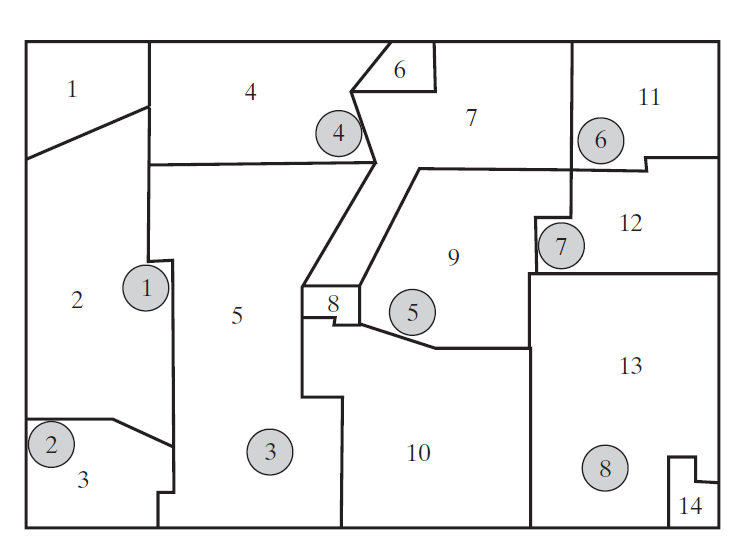

In [2]:
def integer_var_series(df, mdl,**kargs):
    return pd.Series(mdl.integer_var_list(df.index, **kargs), index = df.index)

def continuous_var_series(df, mdl,**kargs):
    return pd.Series(mdl.continuous_var_list(df.index, **kargs), index = df.index)

class CplexSum():
    """Function class that adds a series of dvars into a cplex sum expression.
    To be used as a custom aggregation in a groupby.
    Usage:
        df2 = df1.groupby(['a']).agg({'xDVar':CplexSum(engine.mdl)}).rename(columns={'xDVar':'expr'})

    Sums the dvars in the 'xDVar' column into an expression
    """
    def __init__(self, mdl):
        self.mdl = mdl
    def __call__(self, dvar_series):
        return self.mdl.sum(dvar_series)
    
def extract_solution(df, extract_dvar_names=None, drop_column_names=None, drop:bool=True):
    df = df.copy()
    """Generalized routine to extract a solution value. 
    Can remove the dvar column from the df to be able to have a clean df for export into scenario."""
    if extract_dvar_names is not None:
        for xDVarName in extract_dvar_names:
            if xDVarName in df.columns:
                df[f'{xDVarName}_Solution'] = [dvar.solution_value for dvar in df[xDVarName]]
                if drop:
                    df = df.drop([xDVarName], axis = 1)
    if drop and drop_column_names is not None:
        for column in drop_column_names:
            if column in df.columns:
                df = df.drop([column], axis = 1)
    return df 

In [3]:
InputTables = pd.read_excel('facility.xlsx', sheet_name = None)

for i in InputTables.keys():
    del InputTables[i]['Unnamed: 0']
InputTables.keys()


dict_keys(['fixed_costs', 'charges', 'demands', 'capacity'])

In [4]:
mdl = Model("faility_location")

# Decision Variables

a binary decision variable which is 1 if the site is open

In [5]:
sites  = InputTables['fixed_costs'][['site']].set_index('site', verify_integrity=True)
sites['x_is_open'] = integer_var_series(sites, mdl, name = 'x_is_open')
sites = sites.reset_index(drop=False)
sites.head()

,site,x_is_open
0,site_1,x_is_open_site_1
1,site_2,x_is_open_site_2
2,site_3,x_is_open_site_3
3,site_4,x_is_open_site_4
4,site_5,x_is_open_site_5


fraction of demand of a zone that is  fulfilled from a site, a continuous decision variable

In [6]:
fractions = InputTables['charges'][['site','zone']].drop_duplicates().set_index(['site','zone'], verify_integrity=True)
fractions[ 'fractions_satisfied_demands']=continuous_var_series(fractions, mdl, lb=0, ub=1 , name = 'fractions_satisfied_demands')
fractions = fractions.reset_index(drop=False)
fractions.head()

,site,zone,fractions_satisfied_demands
0,site_1,zone_1,fractions_satisfied_demands_site_1_zone_1
1,site_1,zone_2,fractions_satisfied_demands_site_1_zone_2
2,site_1,zone_3,fractions_satisfied_demands_site_1_zone_3
3,site_1,zone_4,fractions_satisfied_demands_site_1_zone_4
4,site_1,zone_5,fractions_satisfied_demands_site_1_zone_5


# Add constraints

#1 summation of fractions_satisfied_demands for each zone, from all sites must be 1

In [7]:
fractions_per_zone = fractions[['zone','fractions_satisfied_demands']].groupby('zone').agg(CplexSum(mdl))
fractions_per_zone.head(2)

,fractions_satisfied_demands
zone,
zone_1,fractions_satisfied_demands_site_1_zone_1+fractions_satisfied_demands_site_2_zone_1+fractions_satisfied_demands_site_3_zone_1+fractions_satisfied_demands_site_4_zone_1+fractions_satisfied_demands_site_5_zone_1+fractions_satisfied_demands_site_6_zone_1+fractions_satisfied_demands_site_7_zone_1+fractions_satisfied_demands_site_8_zone_1
zone_10,fractions_satisfied_demands_site_1_zone_10+fractions_satisfied_demands_site_2_zone_10+fractions_satisfied_demands_site_3_zone_10+fractions_satisfied_demands_site_4_zone_10+fractions_satisfied_demands_site_5_zone_10+fractions_satisfied_demands_site_6_zone_10+fractions_satisfied_demands_site_7_zone_10+fractions_satisfied_demands_site_8_zone_10


In [8]:
for row in fractions_per_zone.itertuples():
    mdl.add_constraint(row.fractions_satisfied_demands == 1)

#2  total assigned demand to a site is less than its capacity. The capacity of closed location is zero

In [9]:
MAX = InputTables['capacity']['max'].values[0]
MIN = InputTables['capacity']['min'].values[0]
MIN, MAX

(1500, 5000)

In [10]:
df = pd.merge(fractions, InputTables['demands'][['zone','demand']],on = ['zone'], how = 'outer')
df['fulfilled_demand']=df['fractions_satisfied_demands']* df['demand']
df.head()

,site,zone,fractions_satisfied_demands,demand,fulfilled_demand
0,site_1,zone_1,fractions_satisfied_demands_site_1_zone_1,250,250fractions_satisfied_demands_site_1_zone_1
1,site_2,zone_1,fractions_satisfied_demands_site_2_zone_1,250,250fractions_satisfied_demands_site_2_zone_1
2,site_3,zone_1,fractions_satisfied_demands_site_3_zone_1,250,250fractions_satisfied_demands_site_3_zone_1
3,site_4,zone_1,fractions_satisfied_demands_site_4_zone_1,250,250fractions_satisfied_demands_site_4_zone_1
4,site_5,zone_1,fractions_satisfied_demands_site_5_zone_1,250,250fractions_satisfied_demands_site_5_zone_1


In [11]:
fulfilled_demand_per_site = df[['site','fulfilled_demand']].groupby('site').agg(CplexSum(mdl))
fulfilled_demand_per_site = pd.merge(fulfilled_demand_per_site,sites, on = ['site'] )
fulfilled_demand_per_site['max_capacity']= MAX
fulfilled_demand_per_site['min_capacity']= MIN
fulfilled_demand_per_site.head(2)

,site,fulfilled_demand,x_is_open,max_capacity,min_capacity
0,site_1,250fractions_satisfied_demands_site_1_zone_1+150fractions_satisfied_demands_site_1_zone_2+1000fractions_satisfied_demands_site_1_zone_3+80fractions_satisfied_demands_site_1_zone_4+50fractions_satisfied_demands_site_1_zone_5+800fractions_satisfied_demands_site_1_zone_6+325fractions_satisfied_demands_site_1_zone_7+100fractions_satisfied_demands_site_1_zone_8+475fractions_satisfied_demands_site_1_zone_9+220fractions_satisfied_demands_site_1_zone_10+900fractions_satisfied_demands_site_1_zone_11+1500fractions_satisfied_demands_site_1_zone_12+430fractions_satisfied_demands_site_1_zone_13+200fractions_satisfied_demands_site_1_zone_14,x_is_open_site_1,5000,1500
1,site_2,250fractions_satisfied_demands_site_2_zone_1+150fractions_satisfied_demands_site_2_zone_2+1000fractions_satisfied_demands_site_2_zone_3+80fractions_satisfied_demands_site_2_zone_4+50fractions_satisfied_demands_site_2_zone_5+800fractions_satisfied_demands_site_2_zone_6+325fractions_satisfied_demands_site_2_zone_7+100fractions_satisfied_demands_site_2_zone_8+475fractions_satisfied_demands_site_2_zone_9+220fractions_satisfied_demands_site_2_zone_10+900fractions_satisfied_demands_site_2_zone_11+1500fractions_satisfied_demands_site_2_zone_12+430fractions_satisfied_demands_site_2_zone_13+200fractions_satisfied_demands_site_2_zone_14,x_is_open_site_2,5000,1500


In [12]:
for row in fulfilled_demand_per_site.itertuples():
    mdl.add_constraint(row.fulfilled_demand <= row.x_is_open * row.max_capacity)

for row in fulfilled_demand_per_site.itertuples():
    mdl.add_constraint(row.fulfilled_demand >= row.x_is_open * row.min_capacity)    

# KPI and Objective Function

demand fullfilment cost = sume over zones :

[(total demand of zone j) * (fraction of demand of zone j that is being fulfilled from site i) * (cost of fulfilment of demand of zone j from site i) ]



In [13]:
df= pd.merge( InputTables['charges'], InputTables['demands'] , on = 'zone', how = 'outer')
df = pd.merge(df, fractions, on = ['zone','site'], how = 'outer')
df.head()

,zone,site,call_charge,demand,fractions_satisfied_demands
0,zone_1,site_1,1.25,250,fractions_satisfied_demands_site_1_zone_1
1,zone_1,site_2,1.40,250,fractions_satisfied_demands_site_2_zone_1
2,zone_1,site_3,1.10,250,fractions_satisfied_demands_site_3_zone_1
3,zone_1,site_4,0.90,250,fractions_satisfied_demands_site_4_zone_1
4,zone_1,site_5,1.50,250,fractions_satisfied_demands_site_5_zone_1


In [14]:
df['demand_fraction_cost'] = df['demand'] * df['call_charge'] * df['fractions_satisfied_demands']

total_demand_cost = mdl.sum(df['demand_fraction_cost'])
mdl.add_kpi(total_demand_cost   , "total_demand_cost")

DecisionKPI(name=total_demand_cost,expr=312.500fractions_satisfied_demands_site_1_zone_1+120fractions_sa..)

In [15]:
df2 = pd.merge ( InputTables['fixed_costs'], sites, on = ['site'])
fixed_costs = mdl.scal_prod( df2['x_is_open'], df2['fixed_cost'])

mdl.add_kpi(fixed_costs   , "fixed_costs")

DecisionKPI(name=fixed_costs,expr=2400x_is_open_site_1+7000x_is_open_site_2+3600x_is_open_site_3+1..)

# Solve

In [16]:
mdl.minimize(fixed_costs+total_demand_cost)
mdl.solve()

mdl.report()

* model faility_location solved with objective = 10153.000
*  KPI: total_demand_cost = 6553.000
*  KPI: fixed_costs       = 3600.000


# Postprocessing

In [17]:
open_sites = extract_solution(sites, extract_dvar_names=['x_is_open'], drop=True)
open_sites=open_sites[open_sites['x_is_open_Solution']==1]
open_sites

,site,x_is_open_Solution
3,site_4,1.0
7,site_8,1.0


In [18]:
fractions = extract_solution(fractions, extract_dvar_names=['fractions_satisfied_demands'], drop=True)
fractions=fractions[fractions['fractions_satisfied_demands_Solution']>.001]  
fractions

,site,zone,fractions_satisfied_demands_Solution
42,site_4,zone_1,1.0
43,site_4,zone_2,1.0
45,site_4,zone_4,1.0
46,site_4,zone_5,1.0
47,site_4,zone_6,1.0
48,site_4,zone_7,1.0
100,site_8,zone_3,1.0
105,site_8,zone_8,1.0
106,site_8,zone_9,1.0
107,site_8,zone_10,1.0


In [19]:
used_capacity = extract_solution(fulfilled_demand_per_site, extract_dvar_names=['fulfilled_demand','x_is_open'], drop=True)
used_capacity = used_capacity[used_capacity['x_is_open_Solution']>0.01]
used_capacity

,site,max_capacity,min_capacity,fulfilled_demand_Solution,x_is_open_Solution
3,site_4,5000,1500,1654.999928,1.0
7,site_8,5000,1500,4824.999993,1.0


In [20]:
OutputTables = {}
OutputTables['open_sites'] = open_sites
OutputTables['fractions'] = fractions
OutputTables['used_capacity'] = used_capacity


In [21]:
io = {**InputTables, **OutputTables}
writer = pd.ExcelWriter('facility_output.xlsx', engine='openpyxl') 

for df_name, df in io.items():
    df.to_excel(writer, sheet_name=df_name)
writer.close()
;

''